# Explore multiple datasets

In this notebook, we are going to experiment with characterising the three datasets that we have in terms of data quality and demographic characteristics.

This notebook is intended to be run on the exported, federated csv file. The file should be exported using `Federating and saving multiple datasets.ipynb`

### First, we read the data and extract the most common purpose labels

In [1]:
import pandas as pd
import numpy as np
import geojson as gj
import sklearn.cluster as sc
import sklearn.metrics.pairwise as smp
import sklearn.metrics as sm

In [2]:
import json
import copy

In [3]:
import folium
import branca.element as bre

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
import seaborn as sns

In [5]:
from IPython import display
from uuid import UUID

import bson.json_util as bju
import bson.objectid as boi

In [6]:
import emission.storage.timeseries.abstract_timeseries as esta
import emission.storage.decorations.trip_queries as esdtq
import emission.analysis.modelling.tour_model.similarity as eamts

storage not configured, falling back to sample, default configuration
Connecting to database URL localhost


In [7]:
import emission.core.wrapper.entry as ecwe
import emission.core.wrapper.confirmedtrip as ecwct

### Read data and setup variables

In [8]:
all_expanded_df = pd.read_json(open("/tmp/federated_trip_only_dataset.json"), orient="records", typ="frame")
for id_col in ["_id", "raw_trip", "start_place", "end_place", "cleaned_trip"]:
    all_expanded_df[id_col] = all_expanded_df[id_col].apply(lambda i: boi.ObjectId(i["$oid"]))
    
all_expanded_df["user_id"] = all_expanded_df["user_id"].apply(lambda u: UUID(u["$uuid"]))
all_expanded_df.tail()

,index,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,...,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts,mode_confirm,purpose_confirm,replaced_mode,program
4601,7,DwellSegmentationTimeFilter,1.624731e+09,2021-06-26T11:15:31.998000-07:00,"{'type': 'Point', 'coordinates': [-122.0838579...",60d77cba26169223a55c6d40,1.624731e+09,2021-06-26T11:10:42.837520-07:00,"{'type': 'Point', 'coordinates': [-122.0864355...",289.160480,...,31,5,America/Los_Angeles,60d77cbb26169223a55c6d7f,a3587c47-863c-4ff1-9618-80b9369aafda,1.624735e+09,walk,shopping,bike,stage
4602,8,DwellSegmentationTimeFilter,1.624733e+09,2021-06-26T11:46:51.764000-07:00,"{'type': 'Point', 'coordinates': [-122.0864558...",60d77cba26169223a55c6d42,1.624732e+09,2021-06-26T11:34:00.745981-07:00,"{'type': 'Point', 'coordinates': [-122.0838579...",771.018019,...,51,5,America/Los_Angeles,60d77cbb26169223a55c6d80,a3587c47-863c-4ff1-9618-80b9369aafda,1.624735e+09,walk,home,bike,stage
4603,9,DwellSegmentationTimeFilter,1.624744e+09,2021-06-26T14:41:14.938000-07:00,"{'type': 'Point', 'coordinates': [-122.1456522...",60d7b5001257dbd47fb4a8bb,1.624742e+09,2021-06-26T14:07:14.774000-07:00,"{'type': 'Point', 'coordinates': [-122.0988551...",2040.164000,...,14,5,America/Los_Angeles,60d7b5011257dbd47fb4a933,a3587c47-863c-4ff1-9618-80b9369aafda,1.624749e+09,bike,shopping,shared_ride,stage
4604,10,DwellSegmentationTimeFilter,1.624744e+09,2021-06-26T14:52:03-07:00,"{'type': 'Point', 'coordinates': [-122.1448623...",60d7b5001257dbd47fb4a8bf,1.624744e+09,2021-06-26T14:45:43.796328-07:00,"{'type': 'Point', 'coordinates': [-122.1456522...",379.203672,...,3,5,America/Los_Angeles,60d7b5011257dbd47fb4a934,a3587c47-863c-4ff1-9618-80b9369aafda,1.624749e+09,walk,shopping,walk,stage
4605,11,DwellSegmentationTimeFilter,1.624748e+09,2021-06-26T15:48:28.779000-07:00,"{'type': 'Point', 'coordinates': [-122.0864782...",60d7c30aaebfe4149daab64e,1.624746e+09,2021-06-26T15:16:34.849586-07:00,"{'type': 'Point', 'coordinates': [-122.1448623...",1913.929414,...,28,5,America/Los_Angeles,60d7c30baebfe4149daab69d,a3587c47-863c-4ff1-9618-80b9369aafda,1.624753e+09,bike,home,drove_alone,stage


In [9]:
all_expanded_df.columns

Index(['index', 'source', 'end_ts', 'end_fmt_time', 'end_loc', 'raw_trip',
       'start_ts', 'start_fmt_time', 'start_loc', 'duration', 'distance',
       'start_place', 'end_place', 'cleaned_trip', 'user_input',
       'start_local_dt_year', 'start_local_dt_month', 'start_local_dt_day',
       'start_local_dt_hour', 'start_local_dt_minute', 'start_local_dt_second',
       'start_local_dt_weekday', 'start_local_dt_timezone',
       'end_local_dt_year', 'end_local_dt_month', 'end_local_dt_day',
       'end_local_dt_hour', 'end_local_dt_minute', 'end_local_dt_second',
       'end_local_dt_weekday', 'end_local_dt_timezone', '_id', 'user_id',
       'metadata_write_ts', 'mode_confirm', 'purpose_confirm', 'replaced_mode',
       'program'],
      dtype='object')

In [10]:
def get_unique_program(user_id):
    all_programs = all_expanded_df[all_expanded_df.user_id == user_id]["program"].unique()
    assert len(all_programs) == 1, f"all_programs = {all_programs}"
    return all_programs[0]

participant_df = pd.DataFrame(all_expanded_df.user_id.unique(), columns=["user_id"])
participant_df = participant_df[participant_df.user_id != 0]
participant_df.set_index("user_id", inplace=True, drop=True)
participant_df["program"] = [get_unique_program(u) for u in participant_df.index]
participant_df

,program
user_id,
576e37c7-ab7e-4c03-add7-02486bc3f42e,minipilot
8b563348-52b3-4e3e-b046-a0aaf4fcea15,minipilot
5079bb93-c9cf-46d7-a643-dfc86bb05605,minipilot
feabfccd-dd6c-4e8e-8517-9d7177042483,minipilot
113aef67-400e-4e21-a29f-d04e50fc42ea,minipilot
c8b9fe22-86f8-449a-b64f-c18a8d20eefc,minipilot
e7b24d99-324d-4d6d-b247-9edc87d3c848,minipilot
1044195f-af9e-43d4-9407-60594e5e9938,minipilot
898b1a5e-cdd4-4a0c-90e4-942fa298e456,minipilot


In [11]:
modeling_support_objects = {}

In [12]:
FINAL_RADIUS = 500
FINAL_FILTER_OURSIM = False
FINAL_CUTOFF_OURSIM = False
FINAL_POINT_DBSCAN = sc.DBSCAN(FINAL_RADIUS, min_samples=2, metric="precomputed")
FINAL_TRIP_DBSCAN = sc.DBSCAN(FINAL_RADIUS * 2, min_samples=2, metric="precomputed")

### Standard functions (currently copied over from other notebooks; should be refactored into a python file)

In [13]:
def get_loc_df(loc_series):
    loc_df = pd.DataFrame(loc_series.apply(lambda p: p["coordinates"]).to_list(), columns=["longitude", "latitude"])
    # display.display(end_loc_df.head())
    return loc_df

In [14]:
def get_distance_matrix(loc_df):
    EARTH_RADIUS = 6371000
    radians_lat_lon = np.radians(loc_df[["latitude", "longitude"]])
    dist_matrix_meters = pd.DataFrame(smp.haversine_distances(radians_lat_lon, radians_lat_lon) * 6371000)
    return dist_matrix_meters

In [15]:
def add_loc_clusters(user_id, modeling_support_objects, trip_df):
    user_trip_df = trip_df[trip_df.user_id == user_id]
    start_distance_matrix = get_distance_matrix(get_loc_df(user_trip_df.start_loc))
    end_distance_matrix = get_distance_matrix(get_loc_df(user_trip_df.end_loc))
    start_loc_model = copy.copy(FINAL_POINT_DBSCAN).fit(start_distance_matrix)
    end_loc_model = copy.copy(FINAL_POINT_DBSCAN).fit(end_distance_matrix)
    trip_df.loc[user_trip_df.index, "start_loc_cluster"] = start_loc_model.labels_
    trip_df.loc[user_trip_df.index, "end_loc_cluster"] = end_loc_model.labels_

    curr_model_support = modeling_support_objects.get(user_id)
    if curr_model_support is None:
        modeling_support_objects[user_id] = {}
        curr_model_support = modeling_support_objects[user_id]
    curr_model_support["start_distance_matrix"] = start_distance_matrix
    curr_model_support["end_distance_matrix"] = end_distance_matrix   
    curr_model_support["start_loc_model"] = start_loc_model
    curr_model_support["end_loc_model"] = end_loc_model

    return trip_df

In [16]:
def add_trip_clusters_dbscan(user_id, trip_df):
    user_trip_df = trip_df[trip_df.user_id == user_id]
    all_combos = user_trip_df.groupby(["start_loc_cluster", "end_loc_cluster"])
    valid_combos = [p for p in all_combos.groups if p[0] != -1 and p[1] != -1]
    print(f"After validating, all_combos {len(all_combos.groups)} -> {len(valid_combos)}")
    all_combos_dict = dict(all_combos.groups)
    valid_combos_series = pd.Series(valid_combos)
    for g, idxlist in all_combos_dict.items():
        print(g, idxlist)
        match = valid_combos_series[valid_combos_series == g]
        if len(match) == 0:
            print(f"invalid combo {g} found for entries {idxlist}, trip is not in a cluster")
            trip_df.loc[idxlist, "trip_cluster_dbscan"] = -1
        else:
            print(f"valid combo {g} found for entries {idxlist}, setting trip cluster to {match.index[0]}")
            trip_df.loc[idxlist, "trip_cluster_dbscan"] = int(match.index[0])
    return trip_df

In [17]:
def add_ground_truth(trip_df, columns, gt_label):
    unique_tuples = dict(trip_df.groupby(by=columns).groups)
    for i, idxlist in enumerate(unique_tuples.values()):
    # print(i, idxlist)
        trip_df.loc[idxlist, gt_label] = i

In [18]:
def add_trip_clusters_oursim(user_id, modeling_support_objects, trip_df):
    user_trip_df = trip_df[trip_df.user_id == user_id]
    user_trip_list = [ecwe.Entry({"data": ecwct.Confirmedtrip(tr), "_id": tr["_id"], "metadata": {"key": "analysis/confirmed_trip"}}) for tr in user_trip_df.to_dict("records")]
    curr_sim = eamts.similarity(user_trip_list, FINAL_RADIUS, shouldFilter=FINAL_FILTER_OURSIM, cutoff=FINAL_CUTOFF_OURSIM)
    curr_sim.fit()
    trip_df.loc[user_trip_df.index, "trip_cluster_oursim"] = curr_sim.labels_.to_list()
    modeling_support_objects[user_id]["similarity_model"] = curr_sim
    return trip_df

In [19]:
def h_score_no_na(labels_true, labels_pred):
    na_index = labels_true[pd.isna(labels_true)].index
    # Before we set the index to nan; we don't want to have a side effect here!
    new_labels_pred = labels_pred.copy()
    new_labels_pred.loc[na_index] = np.nan
    if (len(na_index) > 0):
        print(f"Dropping nan indices {na_index} before calculating score")
        # print(f"{labels_true.dropna()}, {new_labels_pred.dropna()}")
    return sm.homogeneity_score(labels_true.dropna(), new_labels_pred.dropna())

In [20]:
def request_count(labels_pred):
    # once per real cluster
    # once per noisy point (since it is not in a cluster)
    # once per filtered trip (not really necessary for our current regime, but good to be prepared)
    return np.count_nonzero(labels_pred.unique() >= 0) \
                    + np.count_nonzero(labels_pred == -1) \
                    + np.count_nonzero(labels_pred == -2)

In [21]:
def update_basic_stats(user_id, participant_df, trip_df):
    user_trip_df = trip_df[trip_df.user_id == user_id]
    basic_stats = {}
    basic_stats["n_labeled_trips"] = len(user_trip_df)
    basic_stats["unique_label_combos"] = list(user_trip_df.groupby(["mode_confirm", "purpose_confirm", "replaced_mode"]).groups)
    basic_stats["start_loc_in_cluster"] = np.count_nonzero(user_trip_df.start_loc_cluster != -1)
    basic_stats["end_loc_in_cluster"] = np.count_nonzero(user_trip_df.end_loc_cluster != 1)
    for algo in ["dbscan", "oursim"]:
        print(f"Generating basic stats for {user_id} {len(user_trip_df)}, algo {algo} ")
        basic_stats[f"n_trip_in_cluster_{algo}"] = np.count_nonzero(user_trip_df[f"trip_cluster_{algo}"] != -1)
        # need to add one to the max, since the cluster labels start at 0
        basic_stats[f"n_clusters_{algo}"] = user_trip_df[f"trip_cluster_{algo}"].max() + 1
        basic_stats[f"cluster_trip_ratio_{algo}"] = basic_stats[f"n_clusters_{algo}"] / basic_stats[f"n_trip_in_cluster_{algo}"]
        basic_stats[f"homogeneity_score_{algo}"] = h_score_no_na(user_trip_df.ground_truth_by_tuple, user_trip_df[f"trip_cluster_{algo}"])
        basic_stats[f"request_count_{algo}"] = request_count(user_trip_df[f"trip_cluster_{algo}"])
        basic_stats[f"request_pct_{algo}"] = basic_stats[f"request_count_{algo}"] / basic_stats["n_labeled_trips"]

    # print(f"Adding cols {basic_stats.keys()} with vals {basic_stats.values()}")
    participant_df.loc[user_id, basic_stats.keys()] = basic_stats.values()
    return participant_df

Target exploratory analysis:

- number of users
- number of trips
- labeled trip/user distribution
- number of unique combinations of labels
- distribution of unique combination of labels (overall)
- distribution of unique combination of labels (per-user)
- number of trips whose end point is in a cluster
- number of trips whose start point is in a cluster
- number of trips where trip is in a cluster
- number of clusters

In [22]:
for u in participant_df.index:
    all_expanded_df = add_trip_clusters_dbscan(u, add_loc_clusters(u, modeling_support_objects,all_expanded_df))
    add_trip_clusters_oursim(u, modeling_support_objects, all_expanded_df)
    add_ground_truth(all_expanded_df, ["mode_confirm", "purpose_confirm", "replaced_mode"], "ground_truth_by_tuple")

After validating, all_combos 52 -> 41
(-1.0, -1.0) Int64Index([45, 46], dtype='int64')
invalid combo (-1.0, -1.0) found for entries Int64Index([45, 46], dtype='int64'), trip is not in a cluster
(-1.0, 0.0) Int64Index([13, 27, 38, 47, 49, 68, 71, 80, 90, 98, 115, 129, 131, 169, 209], dtype='int64')
invalid combo (-1.0, 0.0) found for entries Int64Index([13, 27, 38, 47, 49, 68, 71, 80, 90, 98, 115, 129, 131, 169, 209], dtype='int64'), trip is not in a cluster
(-1.0, 5.0) Int64Index([164], dtype='int64')
invalid combo (-1.0, 5.0) found for entries Int64Index([164], dtype='int64'), trip is not in a cluster
(-1.0, 12.0) Int64Index([112], dtype='int64')
invalid combo (-1.0, 12.0) found for entries Int64Index([112], dtype='int64'), trip is not in a cluster
(0.0, -1.0) Int64Index([0], dtype='int64')
invalid combo (0.0, -1.0) found for entries Int64Index([0], dtype='int64'), trip is not in a cluster
(0.0, 5.0) Int64Index([136], dtype='int64')
valid combo (0.0, 5.0) found for entries Int64Index(

After validating, all_combos 1 -> 0
(-1.0, -1.0) Int64Index([226], dtype='int64')
invalid combo (-1.0, -1.0) found for entries Int64Index([226], dtype='int64'), trip is not in a cluster
After validating, all_combos 82 -> 62
(-1.0, -1.0) Int64Index([312, 313, 330, 331], dtype='int64')
invalid combo (-1.0, -1.0) found for entries Int64Index([312, 313, 330, 331], dtype='int64'), trip is not in a cluster
(-1.0, 1.0) Int64Index([336, 380], dtype='int64')

/Users/kshankar/miniconda-4.8.3/envs/emission-private-eval/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys



invalid combo (-1.0, 1.0) found for entries Int64Index([336, 380], dtype='int64'), trip is not in a cluster
(-1.0, 2.0) Int64Index([317, 390, 404], dtype='int64')
invalid combo (-1.0, 2.0) found for entries Int64Index([317, 390, 404], dtype='int64'), trip is not in a cluster
(-1.0, 3.0) Int64Index([260, 293, 314, 327, 343, 357, 359, 363, 366, 386, 416, 419], dtype='int64')
invalid combo (-1.0, 3.0) found for entries Int64Index([260, 293, 314, 327, 343, 357, 359, 363, 366, 386, 416, 419], dtype='int64'), trip is not in a cluster
(-1.0, 4.0) Int64Index([236], dtype='int64')
invalid combo (-1.0, 4.0) found for entries Int64Index([236], dtype='int64'), trip is not in a cluster
(-1.0, 8.0) Int64Index([411], dtype='int64')
invalid combo (-1.0, 8.0) found for entries Int64Index([411], dtype='int64'), trip is not in a cluster
(-1.0, 10.0) Int64Index([394, 417], dtype='int64')
invalid combo (-1.0, 10.0) found for entries Int64Index([394, 417], dtype='int64'), trip is not in a cluster
(-1.0, 11

After validating, all_combos 16 -> 13
(-1.0, 0.0) Int64Index([536], dtype='int64')
invalid combo (-1.0, 0.0) found for entries Int64Index([536], dtype='int64'), trip is not in a cluster
(-1.0, 2.0) Int64Index([642], dtype='int64')
invalid combo (-1.0, 2.0) found for entries Int64Index([642], dtype='int64'), trip is not in a cluster
(0.0, -1.0) Int64Index([535, 537], dtype='int64')
invalid combo (0.0, -1.0) found for entries Int64Index([535, 537], dtype='int64'), trip is not in a cluster
(0.0, 0.0) Int64Index([439, 440, 441, 442, 443, 447, 451, 453, 456, 458, 459, 460, 461,
            462, 464, 466, 468, 471, 477, 481, 483, 484, 488, 490, 494, 496,
            498, 500, 502, 506, 507, 512, 514, 515, 516, 517, 518, 520, 521,
            525, 531, 533, 534, 538, 541, 546, 550, 552, 554, 556, 561, 563,
            565, 567, 569, 570, 571, 574, 576, 578, 581, 584, 587, 588, 590,
            591, 593, 595, 596, 598, 600, 602, 603, 604, 607, 610, 612, 613,
            615, 617, 619, 620, 622

After validating, all_combos 24 -> 16
(-1.0, -1.0) Int64Index([860, 876, 893, 928], dtype='int64')
invalid combo (-1.0, -1.0) found for entries Int64Index([860, 876, 893, 928], dtype='int64'), trip is not in a cluster
(-1.0, 0.0) Int64Index([852], dtype='int64')
invalid combo (-1.0, 0.0) found for entries Int64Index([852], dtype='int64'), trip is not in a cluster
(-1.0, 1.0) Int64Index([854, 856, 861, 877, 882, 894, 904, 913, 917], dtype='int64')
invalid combo (-1.0, 1.0) found for entries Int64Index([854, 856, 861, 877, 882, 894, 904, 913, 917], dtype='int64'), trip is not in a cluster
(-1.0, 5.0) Int64Index([929], dtype='int64')
invalid combo (-1.0, 5.0) found for entries Int64Index([929], dtype='int64'), trip is not in a cluster
(0.0, -1.0) Int64Index([853, 900, 927], dtype='int64')
invalid combo (0.0, -1.0) found for entries Int64Index([853, 900, 927], dtype='int64'), trip is not in a cluster
(0.0, 1.0) Int64Index([864, 870, 880, 885, 888, 921, 923, 925], dtype='int64')
valid combo

After validating, all_combos 111 -> 88
(-1.0, -1.0) Int64Index([1333, 1368, 1500, 1539, 1541], dtype='int64')
invalid combo (-1.0, -1.0) found for entries Int64Index([1333, 1368, 1500, 1539, 1541], dtype='int64'), trip is not in a cluster
(-1.0, 0.0) Int64Index([1412, 1501], dtype='int64')
invalid combo (-1.0, 0.0) found for entries Int64Index([1412, 1501], dtype='int64'), trip is not in a cluster
(-1.0, 1.0) Int64Index([1477], dtype='int64')
invalid combo (-1.0, 1.0) found for entries Int64Index([1477], dtype='int64'), trip is not in a cluster
(-1.0, 2.0) Int64Index([1362], dtype='int64')
invalid combo (-1.0, 2.0) found for entries Int64Index([1362], dtype='int64'), trip is not in a cluster
(-1.0, 3.0) Int64Index([1321, 1431, 1472, 1524, 1530, 1533, 1536], dtype='int64')
invalid combo (-1.0, 3.0) found for entries Int64Index([1321, 1431, 1472, 1524, 1530, 1533, 1536], dtype='int64'), trip is not in a cluster
(-1.0, 4.0) Int64Index([1318], dtype='int64')
invalid combo (-1.0, 4.0) found

After validating, all_combos 80 -> 69
(-1.0, -1.0) Int64Index([1758, 1759, 1768, 1774], dtype='int64')
invalid combo (-1.0, -1.0) found for entries Int64Index([1758, 1759, 1768, 1774], dtype='int64'), trip is not in a cluster
(-1.0, 0.0) Int64Index([1605, 1611, 1621, 1625, 1649, 1651, 1677, 1698, 1760, 1775], dtype='int64')
invalid combo (-1.0, 0.0) found for entries Int64Index([1605, 1611, 1621, 1625, 1649, 1651, 1677, 1698, 1760, 1775], dtype='int64'), trip is not in a cluster
(-1.0, 1.0) Int64Index([1730, 1769], dtype='int64')
invalid combo (-1.0, 1.0) found for entries Int64Index([1730, 1769], dtype='int64'), trip is not in a cluster
(-1.0, 10.0) Int64Index([1596], dtype='int64')
invalid combo (-1.0, 10.0) found for entries Int64Index([1596], dtype='int64'), trip is not in a cluster
(-1.0, 15.0) Int64Index([1740], dtype='int64')
invalid combo (-1.0, 15.0) found for entries Int64Index([1740], dtype='int64'), trip is not in a cluster
(0.0, -1.0) Int64Index([1624, 1650, 1676, 1708, 17

After validating, all_combos 17 -> 12
(-1.0, 0.0) Int64Index([1788], dtype='int64')
invalid combo (-1.0, 0.0) found for entries Int64Index([1788], dtype='int64'), trip is not in a cluster
(-1.0, 2.0) Int64Index([1790, 1791], dtype='int64')
invalid combo (-1.0, 2.0) found for entries Int64Index([1790, 1791], dtype='int64'), trip is not in a cluster
(0.0, -1.0) Int64Index([1800], dtype='int64')
invalid combo (0.0, -1.0) found for entries Int64Index([1800], dtype='int64'), trip is not in a cluster
(0.0, 0.0) Int64Index([1785], dtype='int64')
valid combo (0.0, 0.0) found for entries Int64Index([1785], dtype='int64'), setting trip cluster to 0
(0.0, 2.0) Int64Index([1792], dtype='int64')
valid combo (0.0, 2.0) found for entries Int64Index([1792], dtype='int64'), setting trip cluster to 1
(1.0, -1.0) Int64Index([1787, 1806], dtype='int64')
invalid combo (1.0, -1.0) found for entries Int64Index([1787, 1806], dtype='int64'), trip is not in a cluster
(1.0, 0.0) Int64Index([1786, 1794], dtype='i

(38.0, 1.0) Int64Index([2192], dtype='int64')
valid combo (38.0, 1.0) found for entries Int64Index([2192], dtype='int64'), setting trip cluster to 191
(38.0, 2.0) Int64Index([2345], dtype='int64')
valid combo (38.0, 2.0) found for entries Int64Index([2345], dtype='int64'), setting trip cluster to 192
After validating, all_combos 12 -> 9
(-1.0, -1.0) Int64Index([2434, 2436], dtype='int64')
invalid combo (-1.0, -1.0) found for entries Int64Index([2434, 2436], dtype='int64'), trip is not in a cluster
(-1.0, 1.0) Int64Index([2428, 2435, 2438, 2442, 2444, 2455, 2461, 2463], dtype='int64')
invalid combo (-1.0, 1.0) found for entries Int64Index([2428, 2435, 2438, 2442, 2444, 2455, 2461, 2463], dtype='int64'), trip is not in a cluster
(0.0, -1.0) Int64Index([2427, 2429, 2441, 2443, 2454, 2460, 2462, 2464], dtype='int64')
invalid combo (0.0, -1.0) found for entries Int64Index([2427, 2429, 2441, 2443, 2454, 2460, 2462, 2464], dtype='int64'), trip is not in a cluster
(0.0, 0.0) Int64Index([2425, 

After validating, all_combos 3 -> 1
(-1.0, 0.0) Int64Index([2918], dtype='int64')
invalid combo (-1.0, 0.0) found for entries Int64Index([2918], dtype='int64'), trip is not in a cluster
(0.0, -1.0) Int64Index([2924], dtype='int64')
invalid combo (0.0, -1.0) found for entries Int64Index([2924], dtype='int64'), trip is not in a cluster
(0.0, 0.0) Int64Index([2917, 2919, 2920, 2921, 2922, 2923], dtype='int64')
valid combo (0.0, 0.0) found for entries Int64Index([2917, 2919, 2920, 2921, 2922, 2923], dtype='int64'), setting trip cluster to 0
After validating, all_combos 4 -> 1
(-1.0, 0.0) Int64Index([2925, 2927], dtype='int64')
invalid combo (-1.0, 0.0) found for entries Int64Index([2925, 2927], dtype='int64'), trip is not in a cluster
(-1.0, 1.0) Int64Index([2929, 2930], dtype='int64')
invalid combo (-1.0, 1.0) found for entries Int64Index([2929, 2930], dtype='int64'), trip is not in a cluster
(0.0, -1.0) Int64Index([2928], dtype='int64')
invalid combo (0.0, -1.0) found for entries Int64In

/Users/kshankar/miniconda-4.8.3/envs/emission-private-eval/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys


After validating, all_combos 4 -> 1
(-1.0, -1.0) Int64Index([2966], dtype='int64')
invalid combo (-1.0, -1.0) found for entries Int64Index([2966], dtype='int64'), trip is not in a cluster
(-1.0, 0.0) Int64Index([2950, 2956, 2958, 2967, 2969], dtype='int64')
invalid combo (-1.0, 0.0) found for entries Int64Index([2950, 2956, 2958, 2967, 2969], dtype='int64'), trip is not in a cluster
(0.0, -1.0) Int64Index([2955, 2957, 2965, 2968], dtype='int64')
invalid combo (0.0, -1.0) found for entries Int64Index([2955, 2957, 2965, 2968], dtype='int64'), trip is not in a cluster
(0.0, 0.0) Int64Index([2951, 2952, 2953, 2954, 2959, 2960, 2961, 2962, 2963, 2964, 2970,
            2971],
           dtype='int64')
valid combo (0.0, 0.0) found for entries Int64Index([2951, 2952, 2953, 2954, 2959, 2960, 2961, 2962, 2963, 2964, 2970,
            2971],
           dtype='int64'), setting trip cluster to 0
After validating, all_combos 15 -> 8
(-1.0, -1.0) Int64Index([2985, 3005], dtype='int64')
invalid combo

After validating, all_combos 20 -> 12
(-1.0, -1.0) Int64Index([3278], dtype='int64')
invalid combo (-1.0, -1.0) found for entries Int64Index([3278], dtype='int64'), trip is not in a cluster
(-1.0, 0.0) Int64Index([3261, 3264, 3266, 3271, 3273, 3279, 3293, 3296], dtype='int64')
invalid combo (-1.0, 0.0) found for entries Int64Index([3261, 3264, 3266, 3271, 3273, 3279, 3293, 3296], dtype='int64'), trip is not in a cluster
(-1.0, 2.0) Int64Index([3285], dtype='int64')
invalid combo (-1.0, 2.0) found for entries Int64Index([3285], dtype='int64'), trip is not in a cluster
(-1.0, 3.0) Int64Index([3275], dtype='int64')
invalid combo (-1.0, 3.0) found for entries Int64Index([3275], dtype='int64'), trip is not in a cluster
(0.0, -1.0) Int64Index([3260, 3262, 3265, 3272, 3274, 3277, 3292, 3294, 3297], dtype='int64')
invalid combo (0.0, -1.0) found for entries Int64Index([3260, 3262, 3265, 3272, 3274, 3277, 3292, 3294, 3297], dtype='int64'), trip is not in a cluster
(0.0, 0.0) Int64Index([3259, 3

valid combo (2.0, 9.0) found for entries Int64Index([3408, 3413], dtype='int64'), setting trip cluster to 16
(3.0, 0.0) Int64Index([3431], dtype='int64')
valid combo (3.0, 0.0) found for entries Int64Index([3431], dtype='int64'), setting trip cluster to 17
(3.0, 3.0) Int64Index([3430, 3437], dtype='int64')
valid combo (3.0, 3.0) found for entries Int64Index([3430, 3437], dtype='int64'), setting trip cluster to 18
(3.0, 4.0) Int64Index([3370], dtype='int64')
valid combo (3.0, 4.0) found for entries Int64Index([3370], dtype='int64'), setting trip cluster to 19
(4.0, -1.0) Int64Index([3371], dtype='int64')
invalid combo (4.0, -1.0) found for entries Int64Index([3371], dtype='int64'), trip is not in a cluster
(4.0, 2.0) Int64Index([3374], dtype='int64')
valid combo (4.0, 2.0) found for entries Int64Index([3374], dtype='int64'), setting trip cluster to 20
(5.0, 0.0) Int64Index([3379], dtype='int64')
valid combo (5.0, 0.0) found for entries Int64Index([3379], dtype='int64'), setting trip clu

After validating, all_combos 2 -> 0
(-1.0, -1.0) Int64Index([3776], dtype='int64')
invalid combo (-1.0, -1.0) found for entries Int64Index([3776], dtype='int64'), trip is not in a cluster
(0.0, -1.0) Int64Index([3777, 3778], dtype='int64')
invalid combo (0.0, -1.0) found for entries Int64Index([3777, 3778], dtype='int64'), trip is not in a cluster


/Users/kshankar/miniconda-4.8.3/envs/emission-private-eval/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys


After validating, all_combos 3 -> 0
(-1.0, -1.0) Int64Index([3782], dtype='int64')
invalid combo (-1.0, -1.0) found for entries Int64Index([3782], dtype='int64'), trip is not in a cluster
(-1.0, 0.0) Int64Index([3783, 3784], dtype='int64')
invalid combo (-1.0, 0.0) found for entries Int64Index([3783, 3784], dtype='int64'), trip is not in a cluster
(0.0, -1.0) Int64Index([3779, 3780, 3781], dtype='int64')
invalid combo (0.0, -1.0) found for entries Int64Index([3779, 3780, 3781], dtype='int64'), trip is not in a cluster
After validating, all_combos 30 -> 24
(-1.0, -1.0) Int64Index([3823, 3858, 3859, 3860, 3861], dtype='int64')
invalid combo (-1.0, -1.0) found for entries Int64Index([3823, 3858, 3859, 3860, 3861], dtype='int64'), trip is not in a cluster
(-1.0, 0.0) Int64Index([3815, 3829, 3839, 3841, 3862, 3865], dtype='int64')
invalid combo (-1.0, 0.0) found for entries Int64Index([3815, 3829, 3839, 3841, 3862, 3865], dtype='int64'), trip is not in a cluster

/Users/kshankar/miniconda-4.8.3/envs/emission-private-eval/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys



(-1.0, 1.0) Int64Index([3835], dtype='int64')
invalid combo (-1.0, 1.0) found for entries Int64Index([3835], dtype='int64'), trip is not in a cluster
(-1.0, 7.0) Int64Index([3834], dtype='int64')
invalid combo (-1.0, 7.0) found for entries Int64Index([3834], dtype='int64'), trip is not in a cluster
(0.0, -1.0) Int64Index([3814, 3838, 3840, 3863, 3864], dtype='int64')
invalid combo (0.0, -1.0) found for entries Int64Index([3814, 3838, 3840, 3863, 3864], dtype='int64'), trip is not in a cluster
(0.0, 0.0) Int64Index([3785, 3786, 3787, 3788, 3789, 3790, 3795, 3804, 3805, 3812, 3813,
            3830, 3842, 3857],
           dtype='int64')
valid combo (0.0, 0.0) found for entries Int64Index([3785, 3786, 3787, 3788, 3789, 3790, 3795, 3804, 3805, 3812, 3813,
            3830, 3842, 3857],
           dtype='int64'), setting trip cluster to 0
(0.0, 1.0) Int64Index([3791, 3806, 3808], dtype='int64')
valid combo (0.0, 1.0) found for entries Int64Index([3791, 3806, 3808], dtype='int64'), setting

/Users/kshankar/miniconda-4.8.3/envs/emission-private-eval/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys


After validating, all_combos 30 -> 25
(-1.0, 1.0) Int64Index([3909, 3925, 3935, 3939, 3957, 3975, 3982], dtype='int64')
invalid combo (-1.0, 1.0) found for entries Int64Index([3909, 3925, 3935, 3939, 3957, 3975, 3982], dtype='int64'), trip is not in a cluster
(-1.0, 2.0) Int64Index([3970], dtype='int64')
invalid combo (-1.0, 2.0) found for entries Int64Index([3970], dtype='int64'), trip is not in a cluster
(0.0, -1.0) Int64Index([3934, 3938, 3974, 3981], dtype='int64')
invalid combo (0.0, -1.0) found for entries Int64Index([3934, 3938, 3974, 3981], dtype='int64'), trip is not in a cluster
(0.0, 0.0) Int64Index([3907], dtype='int64')
valid combo (0.0, 0.0) found for entries Int64Index([3907], dtype='int64'), setting trip cluster to 0
(0.0, 1.0) Int64Index([3913, 3933, 3965, 3968, 3969, 3978, 3979, 3980], dtype='int64')
valid combo (0.0, 1.0) found for entries Int64Index([3913, 3933, 3965, 3968, 3969, 3978, 3979, 3980], dtype='int64'), setting trip cluster to 1
(0.0, 2.0) Int64Index([391

/Users/kshankar/miniconda-4.8.3/envs/emission-private-eval/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys


(5.0, 0.0) Int64Index([4040, 4069], dtype='int64')
valid combo (5.0, 0.0) found for entries Int64Index([4040, 4069], dtype='int64'), setting trip cluster to 12
(6.0, 0.0) Int64Index([4046, 4079], dtype='int64')
valid combo (6.0, 0.0) found for entries Int64Index([4046, 4079], dtype='int64'), setting trip cluster to 13
(7.0, 0.0) Int64Index([4053, 4073], dtype='int64')
valid combo (7.0, 0.0) found for entries Int64Index([4053, 4073], dtype='int64'), setting trip cluster to 14
After validating, all_combos 56 -> 40
(-1.0, -1.0) Int64Index([4117, 4118, 4119, 4129, 4130, 4131, 4132, 4133, 4134, 4135, 4157,
            4164, 4167, 4172],
           dtype='int64')
invalid combo (-1.0, -1.0) found for entries Int64Index([4117, 4118, 4119, 4129, 4130, 4131, 4132, 4133, 4134, 4135, 4157,
            4164, 4167, 4172],
           dtype='int64'), trip is not in a cluster
(-1.0, 0.0) Int64Index([4152, 4173], dtype='int64')
invalid combo (-1.0, 0.0) found for entries Int64Index([4152, 4173], dtype='

After validating, all_combos 5 -> 2
(-1.0, 0.0) Int64Index([4220, 4227, 4230], dtype='int64')
invalid combo (-1.0, 0.0) found for entries Int64Index([4220, 4227, 4230], dtype='int64'), trip is not in a cluster
(0.0, -1.0) Int64Index([4226], dtype='int64')
invalid combo (0.0, -1.0) found for entries Int64Index([4226], dtype='int64'), trip is not in a cluster
(0.0, 0.0) Int64Index([4211, 4212, 4213, 4215, 4222, 4223, 4224, 4225], dtype='int64')
valid combo (0.0, 0.0) found for entries Int64Index([4211, 4212, 4213, 4215, 4222, 4223, 4224, 4225], dtype='int64'), setting trip cluster to 0
(1.0, -1.0) Int64Index([4219, 4229], dtype='int64')
invalid combo (1.0, -1.0) found for entries Int64Index([4219, 4229], dtype='int64'), trip is not in a cluster
(1.0, 0.0) Int64Index([4214, 4216, 4217, 4218, 4221, 4228, 4231], dtype='int64')
valid combo (1.0, 0.0) found for entries Int64Index([4214, 4216, 4217, 4218, 4221, 4228, 4231], dtype='int64'), setting trip cluster to 1
After validating, all_combos

After validating, all_combos 16 -> 8
(-1.0, -1.0) Int64Index([4474, 4479], dtype='int64')
invalid combo (-1.0, -1.0) found for entries Int64Index([4474, 4479], dtype='int64'), trip is not in a cluster
(-1.0, 0.0) Int64Index([4471], dtype='int64')
invalid combo (-1.0, 0.0) found for entries Int64Index([4471], dtype='int64'), trip is not in a cluster
(-1.0, 1.0) Int64Index([4466, 4480, 4482, 4484, 4496, 4499, 4502], dtype='int64')
invalid combo (-1.0, 1.0) found for entries Int64Index([4466, 4480, 4482, 4484, 4496, 4499, 4502], dtype='int64'), trip is not in a cluster
(-1.0, 2.0) Int64Index([4468, 4475], dtype='int64')
invalid combo (-1.0, 2.0) found for entries Int64Index([4468, 4475], dtype='int64'), trip is not in a cluster
(0.0, -1.0) Int64Index([4463], dtype='int64')
invalid combo (0.0, -1.0) found for entries Int64Index([4463], dtype='int64'), trip is not in a cluster
(0.0, 0.0) Int64Index([4464], dtype='int64')
valid combo (0.0, 0.0) found for entries Int64Index([4464], dtype='int

/Users/kshankar/miniconda-4.8.3/envs/emission-private-eval/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys


After validating, all_combos 6 -> 3
(-1.0, 0.0) Int64Index([4595, 4600], dtype='int64')
invalid combo (-1.0, 0.0) found for entries Int64Index([4595, 4600], dtype='int64'), trip is not in a cluster
(-1.0, 1.0) Int64Index([4603], dtype='int64')
invalid combo (-1.0, 1.0) found for entries Int64Index([4603], dtype='int64'), trip is not in a cluster
(0.0, -1.0) Int64Index([4594, 4599], dtype='int64')
invalid combo (0.0, -1.0) found for entries Int64Index([4594, 4599], dtype='int64'), trip is not in a cluster
(0.0, 0.0) Int64Index([4596, 4597, 4598, 4601, 4602], dtype='int64')
valid combo (0.0, 0.0) found for entries Int64Index([4596, 4597, 4598, 4601, 4602], dtype='int64'), setting trip cluster to 0
(1.0, 0.0) Int64Index([4605], dtype='int64')
valid combo (1.0, 0.0) found for entries Int64Index([4605], dtype='int64'), setting trip cluster to 1
(1.0, 1.0) Int64Index([4604], dtype='int64')
valid combo (1.0, 1.0) found for entries Int64Index([4604], dtype='int64'), setting trip cluster to 2


In [23]:
for u in participant_df.index:
    update_basic_stats(u, participant_df, all_expanded_df)

Generating basic stats for 576e37c7-ab7e-4c03-add7-02486bc3f42e 226, algo dbscan 
Generating basic stats for 576e37c7-ab7e-4c03-add7-02486bc3f42e 226, algo oursim 
Generating basic stats for 8b563348-52b3-4e3e-b046-a0aaf4fcea15 1, algo dbscan 
Generating basic stats for 8b563348-52b3-4e3e-b046-a0aaf4fcea15 1, algo oursim 
Generating basic stats for 5079bb93-c9cf-46d7-a643-dfc86bb05605 212, algo dbscan 
Generating basic stats for 5079bb93-c9cf-46d7-a643-dfc86bb05605 212, algo oursim 
Generating basic stats for feabfccd-dd6c-4e8e-8517-9d7177042483 217, algo dbscan 
Generating basic stats for feabfccd-dd6c-4e8e-8517-9d7177042483 217, algo oursim 
Generating basic stats for 113aef67-400e-4e21-a29f-d04e50fc42ea 33, algo dbscan 
Generating basic stats for 113aef67-400e-4e21-a29f-d04e50fc42ea 33, algo oursim 
Generating basic stats for c8b9fe22-86f8-449a-b64f-c18a8d20eefc 163, algo dbscan 
Generating basic stats for c8b9fe22-86f8-449a-b64f-c18a8d20eefc 163, algo oursim 
Generating basic stats

/Users/kshankar/miniconda-4.8.3/envs/emission-private-eval/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


Generating basic stats for 71e5c219-a0bc-4394-97f8-56899381b0e4 8, algo dbscan 
Generating basic stats for 71e5c219-a0bc-4394-97f8-56899381b0e4 8, algo oursim 
Generating basic stats for e86ed11b-f17e-40bf-973e-ba6325c83a56 6, algo dbscan 
Generating basic stats for e86ed11b-f17e-40bf-973e-ba6325c83a56 6, algo oursim 
Generating basic stats for aac23ee1-5e21-412f-9430-bbd485751535 2, algo dbscan 
Generating basic stats for aac23ee1-5e21-412f-9430-bbd485751535 2, algo oursim 
Generating basic stats for 7918bd51-9e11-446c-9c79-0f36e9a8faa9 17, algo dbscan 
Generating basic stats for 7918bd51-9e11-446c-9c79-0f36e9a8faa9 17, algo oursim 
Generating basic stats for b0c98c51-4bb9-4c67-9ec3-7814cfbdfc82 22, algo dbscan 
Generating basic stats for b0c98c51-4bb9-4c67-9ec3-7814cfbdfc82 22, algo oursim 
Generating basic stats for d4376620-fbcd-4aab-95bf-8c2e0ecf9adf 41, algo dbscan 
Generating basic stats for d4376620-fbcd-4aab-95bf-8c2e0ecf9adf 41, algo oursim 
Generating basic stats for 802667b

/Users/kshankar/miniconda-4.8.3/envs/emission-private-eval/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/Users/kshankar/miniconda-4.8.3/envs/emission-private-eval/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/Users/kshankar/miniconda-4.8.3/envs/emission-private-eval/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/Users/kshankar/miniconda-4.8.3/envs/emission-private-eval/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


Generating basic stats for ae91f6bc-b25d-4d80-93ba-0159ac220901 9, algo dbscan 
Generating basic stats for ae91f6bc-b25d-4d80-93ba-0159ac220901 9, algo oursim 
Generating basic stats for 7ac4a17a-985f-46b4-9114-c139305aae29 1, algo dbscan 
Generating basic stats for 7ac4a17a-985f-46b4-9114-c139305aae29 1, algo oursim 
Generating basic stats for 5f0ceaa8-d604-426b-b9a9-49629d6a085f 78, algo dbscan 
Generating basic stats for 5f0ceaa8-d604-426b-b9a9-49629d6a085f 78, algo oursim 
Generating basic stats for 659974c8-053a-48ba-a6c6-a3cc4fa31004 1, algo dbscan 
Generating basic stats for 659974c8-053a-48ba-a6c6-a3cc4fa31004 1, algo oursim 
Generating basic stats for 37ae3762-24e7-41f3-8225-775b2102f1a7 111, algo dbscan 
Generating basic stats for 37ae3762-24e7-41f3-8225-775b2102f1a7 111, algo oursim 
Generating basic stats for 405b221a-be9e-43bc-86a5-7ca7fccf2227 114, algo dbscan 
Generating basic stats for 405b221a-be9e-43bc-86a5-7ca7fccf2227 114, algo oursim 
Generating basic stats for 22a

/Users/kshankar/miniconda-4.8.3/envs/emission-private-eval/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/Users/kshankar/miniconda-4.8.3/envs/emission-private-eval/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


### Again, let's focus on one dataset before generalizing to other datasets

In [24]:
minipilot_df = participant_df[participant_df.program == "minipilot"]
minipilot_df.head(n=2)

,program,n_labeled_trips,unique_label_combos,start_loc_in_cluster,end_loc_in_cluster,n_trip_in_cluster_dbscan,n_clusters_dbscan,cluster_trip_ratio_dbscan,homogeneity_score_dbscan,request_count_dbscan,request_pct_dbscan,n_trip_in_cluster_oursim,n_clusters_oursim,cluster_trip_ratio_oursim,homogeneity_score_oursim,request_count_oursim,request_pct_oursim
user_id,,,,,,,,,,,,,,,,,
576e37c7-ab7e-4c03-add7-02486bc3f42e,minipilot,226.0,"[(drove_alone, aseguranza, same_mode), (drove_...",207.0,195.0,192.0,41.0,0.213542,0.583484,75.0,0.331858,226.0,86.0,0.380531,0.758201,86.0,0.380531
8b563348-52b3-4e3e-b046-a0aaf4fcea15,minipilot,1.0,"[(bike, exercise, bike)]",0.0,1.0,0.0,0.0,NaN,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.000000


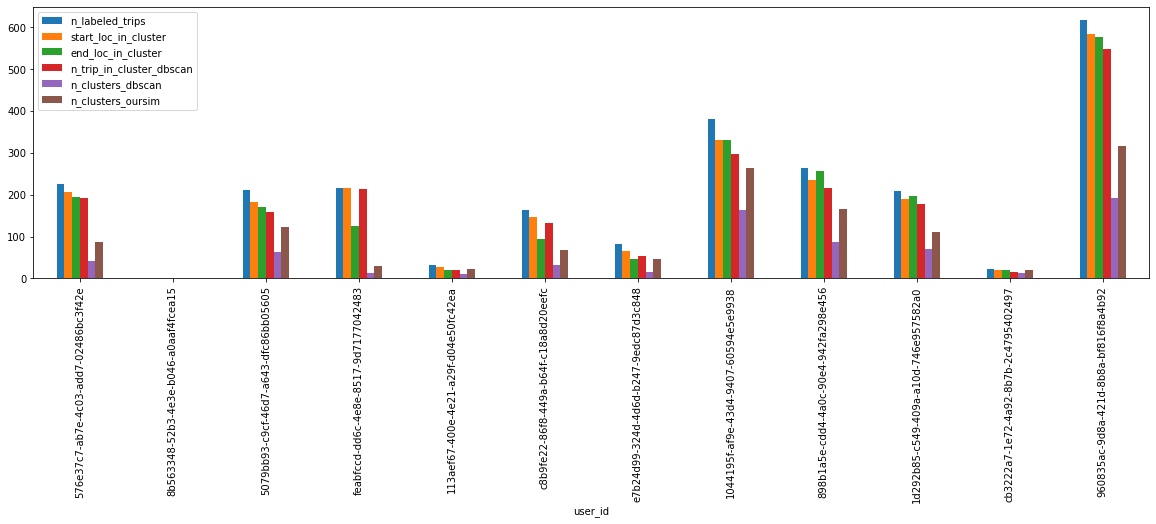

In [25]:
minipilot_df[["n_labeled_trips", "start_loc_in_cluster", "end_loc_in_cluster", "n_trip_in_cluster_dbscan", "n_clusters_dbscan", "n_clusters_oursim"]].plot(kind="bar", figsize=(20,5))

# Final results, generalized to the entire dataset



### First, let's just display everything, without grouping by program

In [26]:
participant_df.columns

Index(['program', 'n_labeled_trips', 'unique_label_combos',
       'start_loc_in_cluster', 'end_loc_in_cluster',
       'n_trip_in_cluster_dbscan', 'n_clusters_dbscan',
       'cluster_trip_ratio_dbscan', 'homogeneity_score_dbscan',
       'request_count_dbscan', 'request_pct_dbscan',
       'n_trip_in_cluster_oursim', 'n_clusters_oursim',
       'cluster_trip_ratio_oursim', 'homogeneity_score_oursim',
       'request_count_oursim', 'request_pct_oursim'],
      dtype='object')

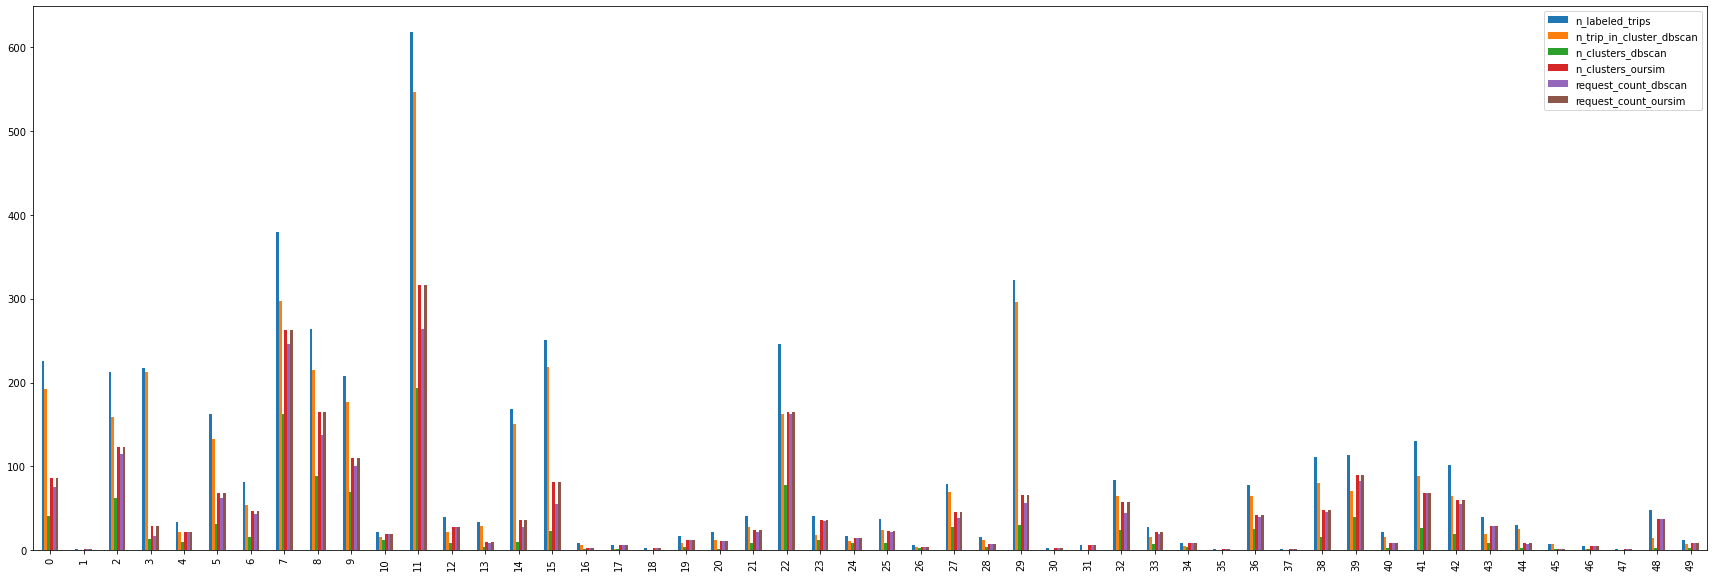

In [27]:
ax = participant_df[["n_labeled_trips", "n_trip_in_cluster_dbscan", "n_clusters_dbscan", "n_clusters_oursim", "request_count_dbscan", "request_count_oursim"]].plot(kind="bar", use_index=False, figsize=(30,10))

### Next, let's group by dataframe to see if there are consistent program level differences

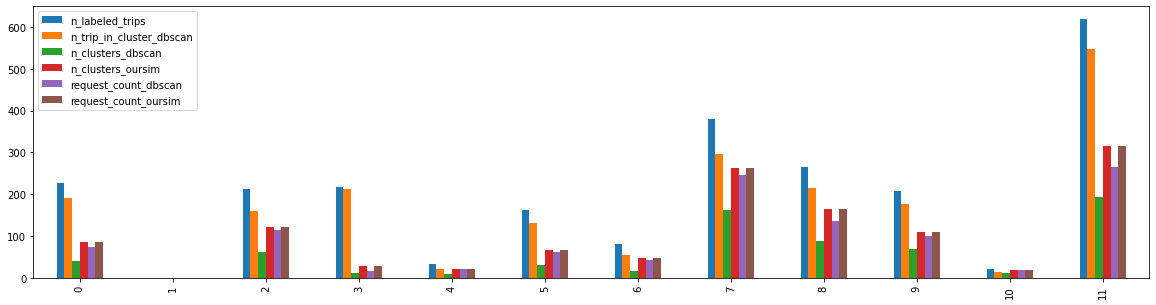

In [28]:
participant_df[participant_df.program == "minipilot"][["n_labeled_trips", "n_trip_in_cluster_dbscan", "n_clusters_dbscan", "n_clusters_oursim", "request_count_dbscan", "request_count_oursim"]].plot(kind="bar", figsize=(20,5), use_index=False)

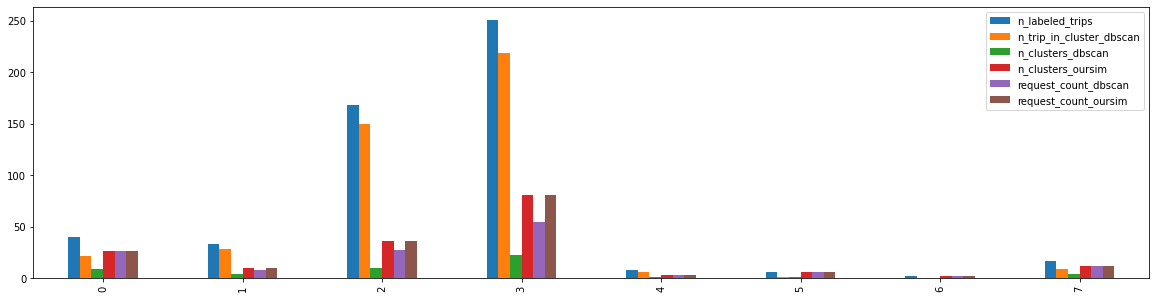

In [29]:
participant_df[participant_df.program == "nrel_lh"][["n_labeled_trips", "n_trip_in_cluster_dbscan", "n_clusters_dbscan", "n_clusters_oursim", "request_count_dbscan", "request_count_oursim"]].plot(kind="bar", figsize=(20,5), use_index=False)

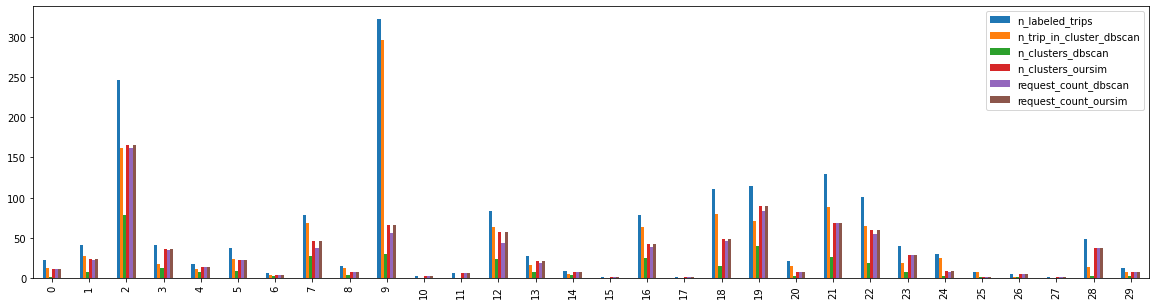

In [30]:
participant_df[participant_df.program == "stage"][["n_labeled_trips", "n_trip_in_cluster_dbscan", "n_clusters_dbscan", "n_clusters_oursim", "request_count_dbscan", "request_count_oursim"]].plot(kind="bar", figsize=(20,5), use_index=False)

### Assessing clustering effectiveness

We use our standard metrics to assess the tradeoff between request pct and homogeneity score.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

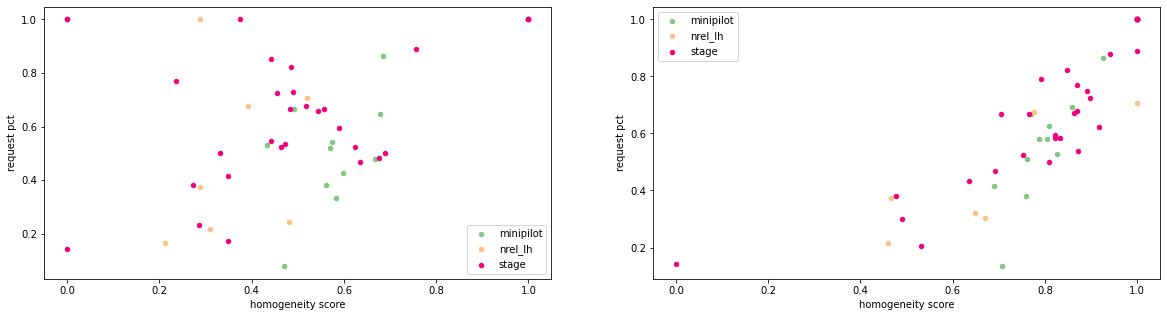

In [31]:
fig = plt.Figure(figsize=(20,5))
axarr = fig.subplots(1,2)
colors = plt.get_cmap("Accent", 4).colors

for i, algo in enumerate(["dbscan", "oursim"]):
    ax = axarr[i]
    # ax = result_df.plot.scatter(x=f"no_filter_no_cutoff_{r}_homogeneity_score_tuple", y=f"no_filter_no_cutoff_{r}_request_pct", label=f"no_filter_no_cutoff_{r}")
    for j, p in enumerate(participant_df.program.unique()):
        curr_p_df = participant_df[participant_df.program==p]
        curr_p_df.plot.scatter(x=f"homogeneity_score_{algo}", y=f"request_pct_{algo}", color=colors[j], label=f"{p}", ax=ax)
    ax.set_xlabel("homogeneity score")
    ax.set_ylabel("request pct")
fig

The request percents on for both the DBSCAN (left) and oursim (right) are similar, but the homogeneity for oursim is clearly better. In fact, we can see a clear linear trend in which a higher request pct leads to better scores. Again, this is an indication that single trip clusters are dominating our results. This is also likely to involve some outliers in which we have very little data to work with.

Let's re-plot with the number of trips to get a sense of that correlation

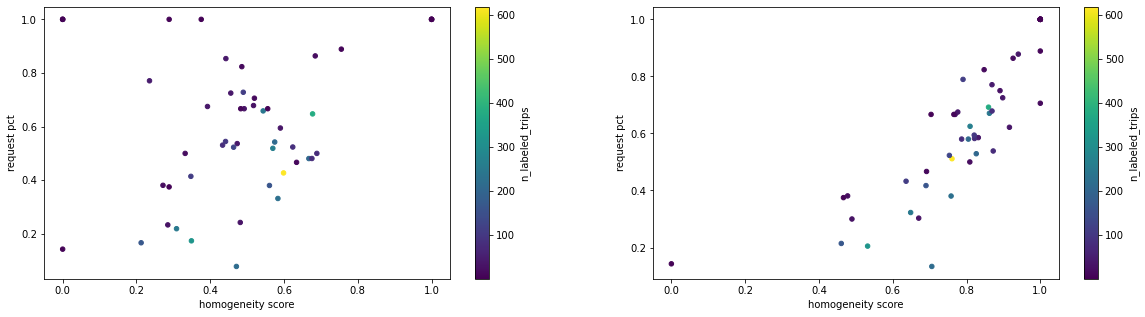

In [32]:
fig = plt.Figure(figsize=(20,5))
axarr = fig.subplots(1,2)
colors = plt.get_cmap("Accent", 4).colors

for i, algo in enumerate(["dbscan", "oursim"]):
    ax = axarr[i]
    participant_df.plot.scatter(x=f"homogeneity_score_{algo}", y=f"request_pct_{algo}", c="n_labeled_trips", cmap="viridis", ax=ax)
    ax.set_xlabel("homogeneity score")
    ax.set_ylabel("request pct")
fig

Since we appear to have a linear relationship between the h-score and the request pct, let's use one of the axes for the number of trips, to see if the visualization becomes more clear.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

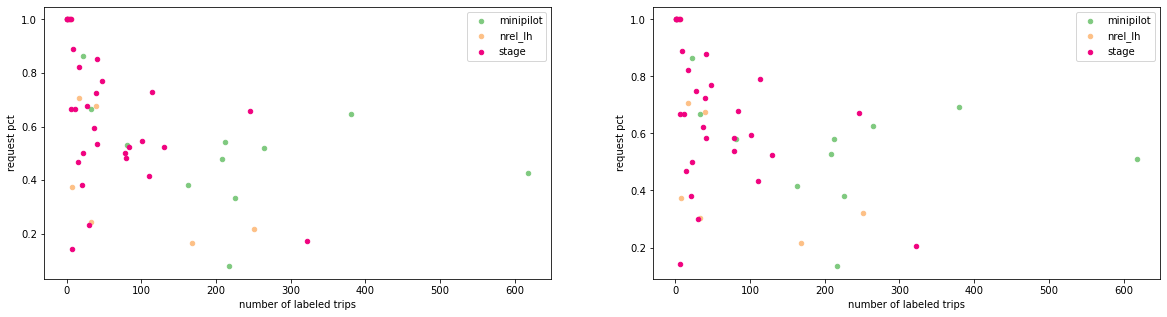

In [33]:
fig = plt.Figure(figsize=(20,5))
axarr = fig.subplots(1,2)
colors = plt.get_cmap("Accent", 4).colors

for i, algo in enumerate(["dbscan", "oursim"]):
    ax = axarr[i]
    for j, p in enumerate(participant_df.program.unique()):
        curr_p_df = participant_df[participant_df.program==p]
        curr_p_df.plot.scatter(x=f"n_labeled_trips", y=f"request_pct_{algo}", ax=ax, color=colors[j], label=p)
    ax.set_xlabel("number of labeled trips")
    ax.set_ylabel("request pct")
fig

The linear scale is resulting in a bunch of points clustered around the edge of the X-axis, with little differentiation between them. Let's try a log scale instead to see if it makes more sense.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

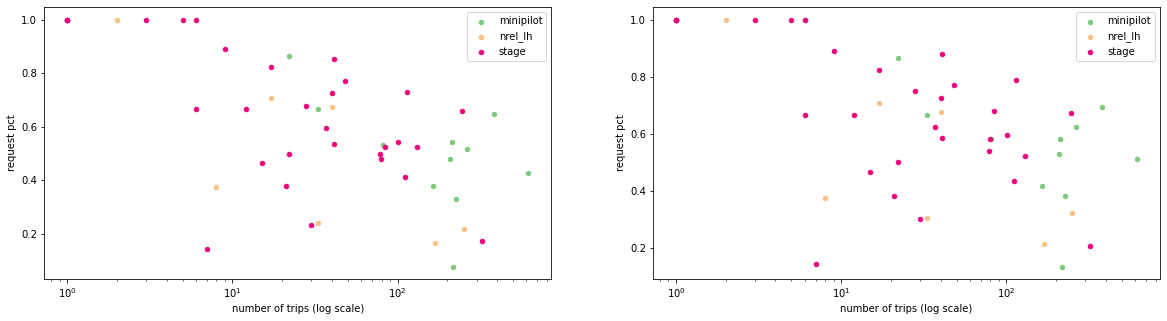

In [34]:
fig = plt.Figure(figsize=(20,5))
axarr = fig.subplots(1,2)
colors = plt.get_cmap("Accent", 4).colors

for i, algo in enumerate(["dbscan", "oursim"]):
    ax = axarr[i]
    for j, p in enumerate(participant_df.program.unique()):
        curr_p_df = participant_df[participant_df.program==p]
        curr_p_df.plot.scatter(x=f"n_labeled_trips", y=f"request_pct_{algo}", ax=ax, color=colors[j], label=p, logx=True)
    ax.set_xlabel("number of trips (log scale)")
    ax.set_ylabel("request pct")
fig

This does appear to show a reasonably clear trend. If we have less than 10 trips, we cannot see any patterns; request_pct = 1. Between 10 and 100 trips, there is a weak trend towards more data providing better results, but it appears to be linear on the log scale, so there is likely some diminishing returns.

Speaking of trends, let us look at more statistical visualizations of these results.

/Users/kshankar/miniconda-4.8.3/envs/emission-private-eval/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/Users/kshankar/miniconda-4.8.3/envs/emission-private-eval/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/Users/kshankar/miniconda-4.8.3/envs/emission-private-eval/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: C

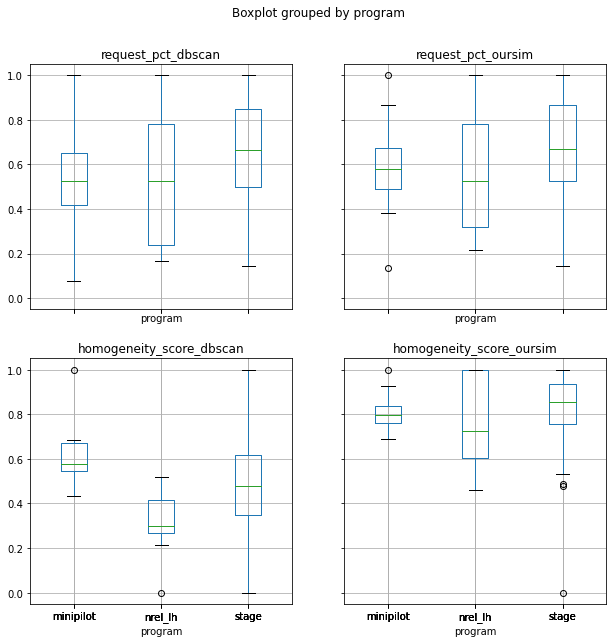

In [35]:
fig = plt.Figure(figsize=(10,10))
axarr = fig.subplots(2,2,sharex=True, sharey=True)
participant_df.boxplot("request_pct_dbscan", by="program", ax=axarr[0][0])
participant_df.boxplot("request_pct_oursim", by="program", ax=axarr[0][1])
participant_df.boxplot("homogeneity_score_dbscan", by="program", ax=axarr[1][0])
participant_df.boxplot("homogeneity_score_oursim", by="program", ax=axarr[1][1])
fig

Again, the request percentages for the programs are similar, but the homogeneity score is significantly better for oursim. Based on the results above, let's plot separately for nTrips > 10 and nTrips > 100, for oursim.

/Users/kshankar/miniconda-4.8.3/envs/emission-private-eval/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/Users/kshankar/miniconda-4.8.3/envs/emission-private-eval/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/Users/kshankar/miniconda-4.8.3/envs/emission-private-eval/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: C

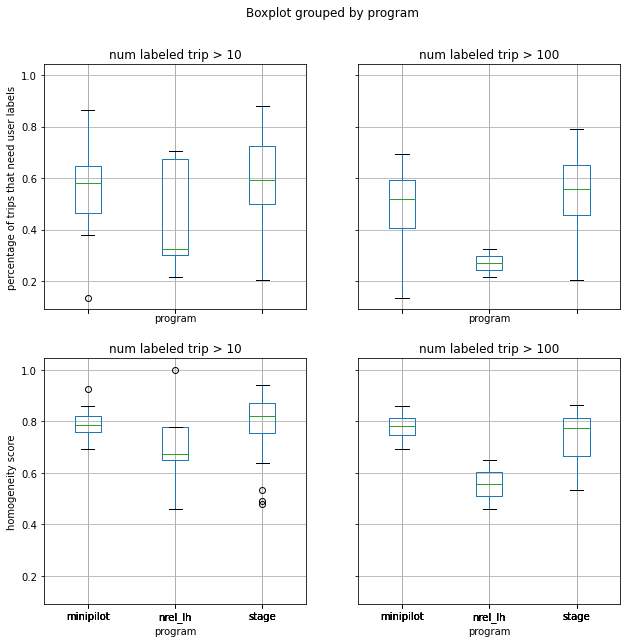

In [46]:
fig = plt.Figure(figsize=(10,10))
axarr = fig.subplots(2,2,sharex=True, sharey=True)
participant_df[participant_df.n_labeled_trips > 10].boxplot("request_pct_oursim", by="program", ax=axarr[0][0])
axarr[0][0].set_title("num labeled trip > 10")
axarr[0][0].set_ylabel("percentage of trips that need user labels")
participant_df[participant_df.n_labeled_trips > 100].boxplot("request_pct_oursim", by="program", ax=axarr[0][1])
axarr[0][1].set_title("num labeled trip > 100")
participant_df[participant_df.n_labeled_trips > 10].boxplot("homogeneity_score_oursim", by="program", ax=axarr[1][0])
axarr[1][0].set_title("num labeled trip > 10")
axarr[1][0].set_ylabel("homogeneity score")
participant_df[participant_df.n_labeled_trips > 100].boxplot("homogeneity_score_oursim", by="program", ax=axarr[1][1])
axarr[1][1].set_title("num labeled trip > 100")
fig

As we can see, that tightens up the results considerably. There are now no outliers, and the IQR is also smaller. It looks like we end up with a mean request % between 0.3 and 0.5 and a mean h-score between 0.5 and 0.7, which seems pretty decent.

### Old estimates using cluster count

Finally, I want to spend a little bit of time focusing on the difference between the request % and the cluster trip ratio to fully understand what is going on. 

I originally came up with the cluster_trip ratio as an evaluation of the "tightness" of the cluster. Trips with a DBSCAN clustering are basically either in a cluster or noise. I found the ratio of the number of clusters to the number of trips in a cluster. If this was low, we would expect few requests, since most of the trips would be squished into a few clusters.

However, the cluster trip ratio boxplot for DBSCAN looks a lot better than the request %. I originally thought that this may be because there might be a lot of noisy trips; note that the cluster trip ratio does not include trips that are *not* in clusters, while the request percentage does.

However, if there are a lot of trips that are not in clusters, then the number of trips *in* the cluster should go down, so the denominator of the cluster_trip_ratio goes down, which increases the ratio. So why isn't that happening?

In [37]:
# participant_df["cluster_trip_ratio"] = participant_df["n_clusters_dbscan"] / participant_df["trip_in_cluster_dbscan"]

/Users/kshankar/miniconda-4.8.3/envs/emission-private-eval/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/Users/kshankar/miniconda-4.8.3/envs/emission-private-eval/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


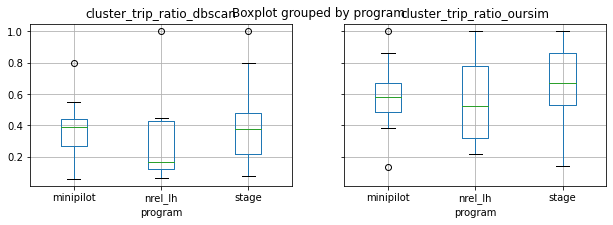

In [38]:
fig = plt.Figure(figsize=(10,3))
axarr = fig.subplots(1,2,sharey=True)
participant_df.boxplot("cluster_trip_ratio_dbscan", by="program", ax=axarr[0])
participant_df.boxplot("cluster_trip_ratio_oursim", by="program", ax=axarr[1])
fig

The NREL LH program does in fact have a better cluster ratio overall than the other two programs. But even in the other two programs, most of the ratios are pretty low. Still, we can't help everybody, and there are going to be a small number of people who are going to have to label more than half their trips. Still, it is gratifying to see that the max overall is just a bit higher than 0.7.

The same data with a slightly different visualization.

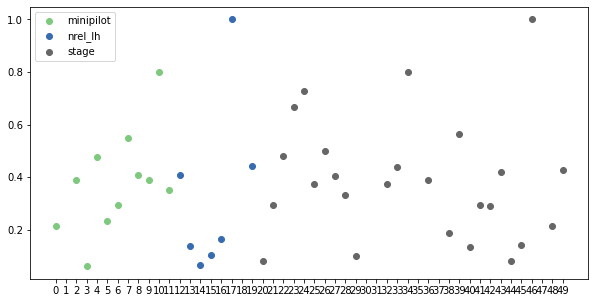

In [39]:
# using plt.scatter here instead of pandas.plot since it is non-trivial to use the index as the x axis
# https://stackoverflow.com/questions/49834883/scatter-plot-form-dataframe-with-index-on-x-axis
# x=df.index does not work for me, may be due to an older version of pandas
color_list = plt.get_cmap("Accent", 3).colors
fig = plt.Figure(figsize=(10,5))
ax = fig.subplots(1,1)
for i, p in enumerate(participant_df.program.unique()):
    curr_p_df = participant_df[participant_df.program==p]
    ax.scatter([str(u) for u in curr_p_df.index], curr_p_df["cluster_trip_ratio_dbscan"], color=color_list[i], label=p)
ax.set_xticklabels(range(0,len(participant_df)))
ax.legend()
fig

### Entries with low cluster trip ratio and high request pct

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

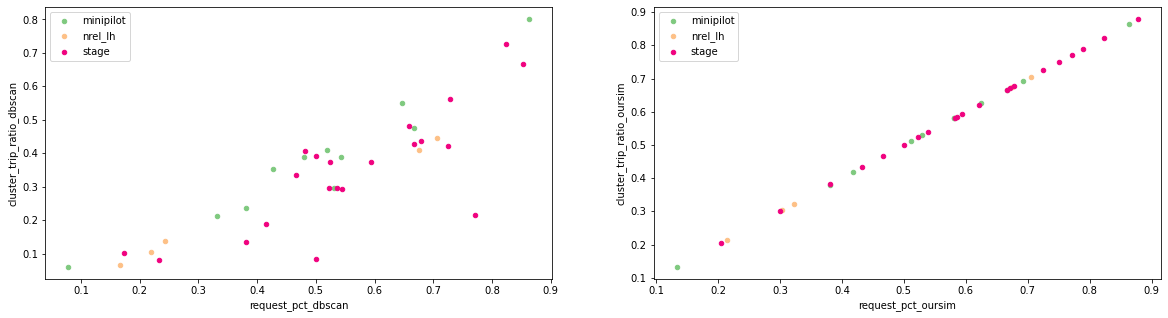

In [40]:
fig = plt.Figure(figsize=(20,5))
axarr = fig.subplots(1,2)
colors = plt.get_cmap("Accent", 4).colors

for i, algo in enumerate(["dbscan", "oursim"]):
    ax = axarr[i]
    for j, p in enumerate(participant_df.program.unique()):
        curr_p_df = participant_df[participant_df.program==p]
        # Focus on trips with > 10 entries for meaningful results
        curr_p_df[curr_p_df.n_labeled_trips > 10].plot.scatter(x=f"request_pct_{algo}", y=f"cluster_trip_ratio_{algo}", ax=ax, color=colors[j], label=p)
fig

While the oursim is essentially a straight line, there are more outliers for DBSCAN.
let's look at some of the outliers for DBSCAN.

In [41]:
participant_df.query("request_pct_dbscan > 0.5 and cluster_trip_ratio_dbscan < 0.3 and n_labeled_trips > 10")[["program", "n_labeled_trips", "n_trip_in_cluster_dbscan", "n_clusters_dbscan", "request_pct_dbscan", "cluster_trip_ratio_dbscan"]]

,program,n_labeled_trips,n_trip_in_cluster_dbscan,n_clusters_dbscan,request_pct_dbscan,cluster_trip_ratio_dbscan
user_id,,,,,,
e7b24d99-324d-4d6d-b247-9edc87d3c848,minipilot,81.0,54.0,16.0,0.530864,0.296296
d4376620-fbcd-4aab-95bf-8c2e0ecf9adf,stage,41.0,27.0,8.0,0.536585,0.296296
f2799dc2-02bc-4249-b42a-4fda8770d1b6,stage,130.0,88.0,26.0,0.523077,0.295455
db4bd43b-9b28-4b9a-b0b6-a751796baeb1,stage,101.0,65.0,19.0,0.544554,0.292308
71f21d53-b655-4637-84f3-a3c63c56707b,stage,48.0,14.0,3.0,0.770833,0.214286


Looking at the entries with the biggest differences:
- **71f21d53**:
  - clusters (2) + trips outside cluster (34) = 36. So request pct is 36/48 = 0.75
  - clusters (2) / trips in cluster (14) = 0.14
  
So basically, the original assumption was correct; it is the noisy points that make a difference. Basically, this happens in the case where there are many noisy clusters, but the points that are within the clusters, compress down well. In that case, the noisy trips carry a lot more weight in the request pct, and excluding them has a much higher impact.

- **a3587c47**:
  - clusters (2) + trips outside cluster (5) = 7. So request pct should be 7/12 = 0.58. **Why is this 0.66 instead?!**
  - clusters (2) / trips in cluster (7) = 0.28
  
There was a mistake in the n_clusters calculation. I was using the max of the column, but the labels start from zero, so the number of clusters is actually the max + 1.

Fixed in notebook. New calculation is:
- **a3587c47**:
  - clusters (3) + trips outside cluster (5) = 8. So request pct should be 8/12 = 0.66.
  - clusters (3) / trips in cluster (7) = 0.42
  
- **71f21d53**:
  - clusters (3) + trips outside cluster (34) = 37. So request pct is 37/48 = 0.77
  - clusters (3) / trips in cluster (14) = 0.21
  
Let's verify this by plotting with the difference in trips as the hue

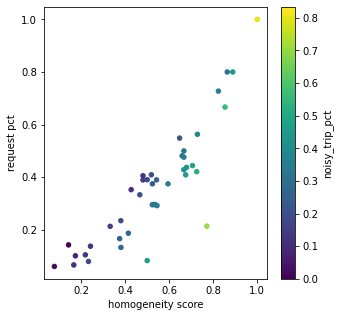

In [42]:
fig = plt.Figure(figsize=(5,5))
ax = fig.subplots(1,1)
colors = plt.get_cmap("Accent", 4).colors

temp_p_df = participant_df.copy()
temp_p_df["noisy_trip_pct"] = temp_p_df.apply(lambda r: r["n_labeled_trips"] - r["n_trip_in_cluster_dbscan"], axis=1) / temp_p_df["n_labeled_trips"]
temp_p_df.plot.scatter(x=f"request_pct_dbscan", y=f"cluster_trip_ratio_dbscan", c="noisy_trip_pct", cmap="viridis", ax=ax)
ax.set_xlabel("homogeneity score")
ax.set_ylabel("request pct")
fig

Alas, not sure that visualization is very useful :(

## DBSCAN-only plots, do not use

These are plots that were primarily created when we were looking at the DBSCAN clustering; they can still be used, but  some of the columns may not make as much sense any more.

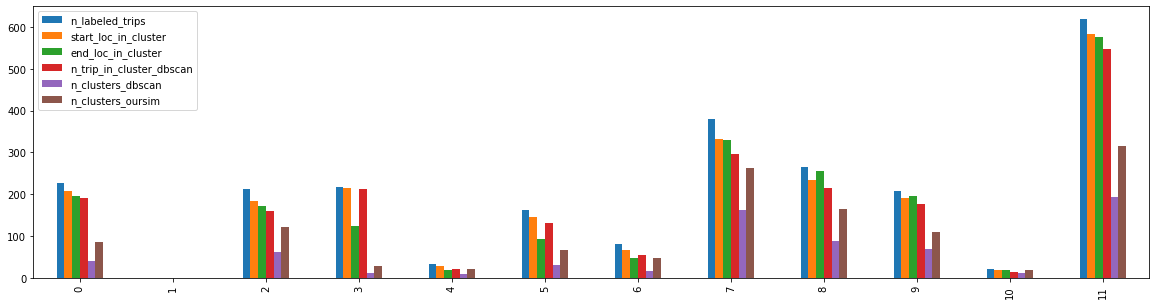

In [43]:
participant_df[participant_df.program == "minipilot"][["n_labeled_trips", "start_loc_in_cluster", "end_loc_in_cluster", "n_trip_in_cluster_dbscan", "n_clusters_dbscan", "n_clusters_oursim"]].plot(kind="bar", figsize=(20,5), use_index=False)

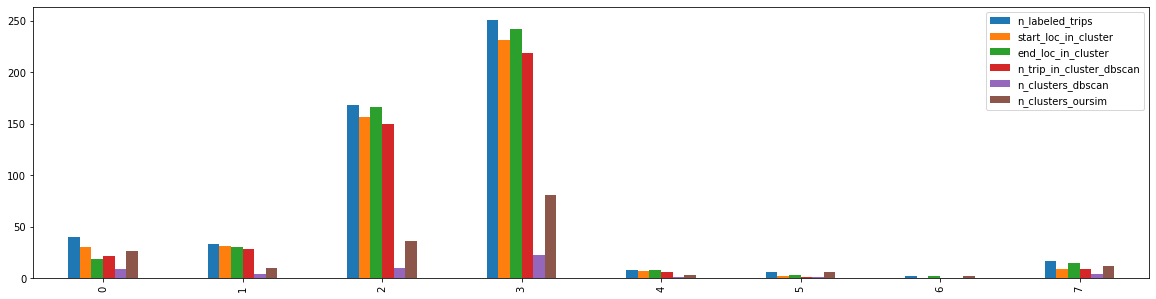

In [44]:
participant_df[participant_df.program == "nrel_lh"][["n_labeled_trips", "start_loc_in_cluster", "end_loc_in_cluster", "n_trip_in_cluster_dbscan", "n_clusters_dbscan", "n_clusters_oursim"]].plot(kind="bar", figsize=(20,5), use_index=False)

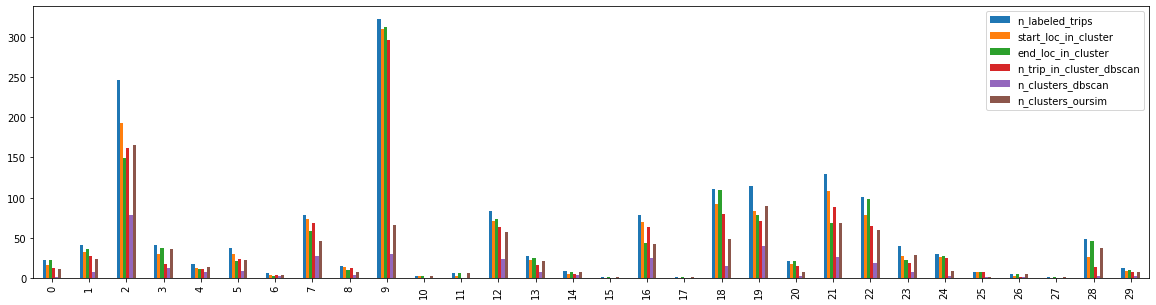

In [45]:
participant_df[participant_df.program == "stage"][["n_labeled_trips", "start_loc_in_cluster", "end_loc_in_cluster", "n_trip_in_cluster_dbscan", "n_clusters_dbscan", "n_clusters_oursim"]].plot(kind="bar", figsize=(20,5), use_index=False)